In [92]:
from typing import Dict, Tuple
import jax
import time
import jax.numpy as jnp
from jax import random
from jax.typing import ArrayLike  # Import ArrayLike
import numpy as np
import matplotlib.pyplot as plt
import sys
# Import the Network class
from pyhgf.model import Network
from pyhgf import load_data
from pyhgf.utils import sample_node_distribution,scan_sampling

# Predictive Agent
In this notebook, we first create two agents: one with a binary child node (where the inputs are observed) and one with a continuous child node.
Rather than merely observing data, we want our agents to think and simulate the future by sampling from their own distributions and then inserting the samples as observations.

In [93]:
#rng_key = random.PRNGKey(0)
rng_key = random.PRNGKey(int(time.time()))

## Continuous Agent
We create an agent with two nodes, including a child continuous node as the input.

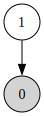

In [94]:
# Define an agent with a continuous node and display the network
agent_1 = (
    Network()  # Create a new network
    .add_nodes(precision=1e2)  # Add Node 1: Continuous node with a specified precision
    .add_nodes(value_children=[0])  # Add Node 2: Child node linked to Node 1
)

# Plot the network structure
agent_1.plot_network()

In [95]:
# Sample from the continuous node
sample = sample_node_distribution(
    agent_1.attributes,        # Attributes of the network
    0,                         # Node index to sample from
    rng_key,                   # Random number generator key
    agent_1.edges[0].node_type # Node type for the specified node
)

# Print the sampled value along with the node's mean and precision
mean = agent_1.attributes[0]['expected_mean']
precision = agent_1.attributes[0]['expected_precision']
print(f"Sampled node with mean of {mean} and a precision of {precision}: {sample}")

Sampled node with mean of 0.0 and a precision of 1.0: (Array(-0.26410845, dtype=float32), Array([3398566719, 1030377080], dtype=uint32))


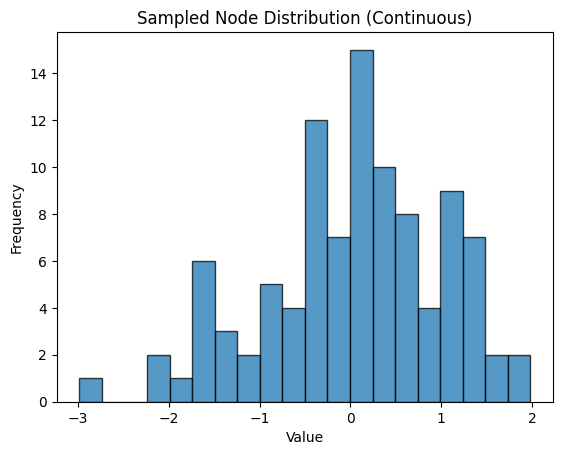

In [96]:
# Run the scan to generate multiple samples
num_samples = 100  # Number of samples to generate
samples = scan_sampling(
    agent_1.attributes,        # Network attributes
    0,                         # Node index to sample from
    rng_key,                   # Random number generator key
    agent_1.edges[0].node_type, # Node type for the specified node
    num_samples                # Number of samples to generate
)

# Plot the sampled distribution
plt.hist(samples, bins=20, alpha=0.75, edgecolor='k')  # Histogram of samples
plt.title("Sampled Node Distribution (Continuous)")    # Title of the plot
plt.xlabel("Value")                                     # X-axis label
plt.ylabel("Frequency")                                 # Y-axis label
plt.show()                                              # Display the plot

## Binary agent

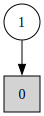

In [97]:
# Define an agent with a binary node and display the network
agent_2 = (
    Network()  # Create a new network
    .add_nodes(kind="binary-state", precision=1e2)  # Add Node 1: Binary state node with a specified precision
    .add_nodes(value_children=[0])  # Add Node 2: Child node linked to Node 1
)

# Plot the network structure
agent_2.plot_network()

In [98]:
# Sample from the binary node
sample = sample_node_distribution(
    agent_2.attributes,        # Attributes of the network
    0,                         # Node index to sample from (Node 1)
    rng_key,                   # Random number generator key
    agent_2.edges[0].node_type # Node type for the specified node
)

# Print the sampled value along with the node's mean and precision
mean = agent_2.attributes[0]['expected_mean']
precision = agent_2.attributes[0]['expected_precision']
print(f"Sampled node with mean of {mean} and a precision of {precision}: {sample}")

Sampled node with mean of 0.5 and a precision of 1.0: (Array(1., dtype=float32), Array([3398566719, 1030377080], dtype=uint32))


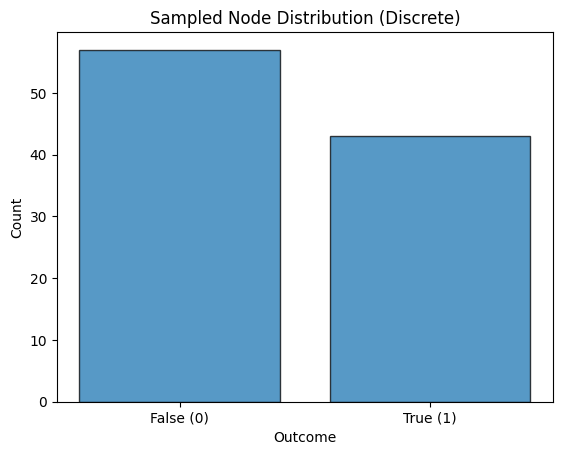

In [99]:
samples = scan_sampling(agent_2.attributes, 0, rng_key, agent_2.edges[0].node_type, num_samples)

# Plot the results
true_count = jnp.sum(samples)
false_count = num_samples - true_count
plt.bar(["False (0)", "True (1)"], [false_count, true_count], alpha=0.75, edgecolor='k')
plt.title("Sampled Node Distribution (Discrete)")
plt.xlabel("Outcome")
plt.ylabel("Count")
plt.show()

## Observing his own sampling
Now, we want the agent to observe its own sampling. This means the agent will sample from its own distribution, treat the sample as an observation, and potentially update its internal state or parameters based on this observation.


array([<Axes: title={'left': 'State Node 1'}, ylabel='$\\mu_{1}$'>,
       <Axes: title={'left': 'Continuous Input Node 0'}, xlabel='Time', ylabel='$\\mu_{0}$'>],
      dtype=object)

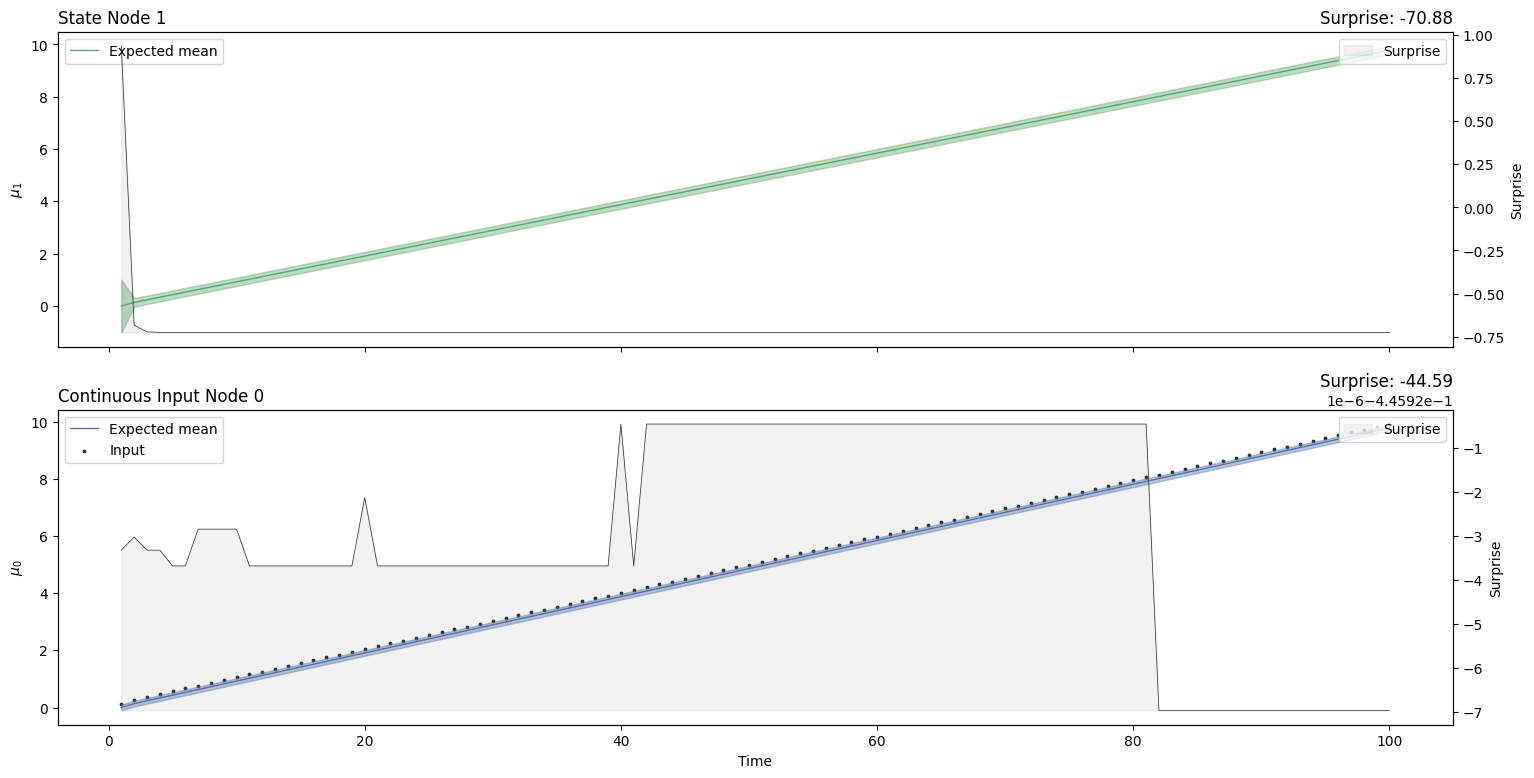

In [100]:
# Generate predictions based on the agent's internal model and inputs
agent_1.input_data_prediction()
# Plot the predicted trajectories to visualize the agent's future states
agent_1.plot_trajectories()

array([<Axes: title={'left': 'State Node 1'}, ylabel='$\\mu_{1}$'>,
       <Axes: title={'left': 'Continuous Input Node 0'}, xlabel='Time', ylabel='$\\mu_{0}$'>],
      dtype=object)

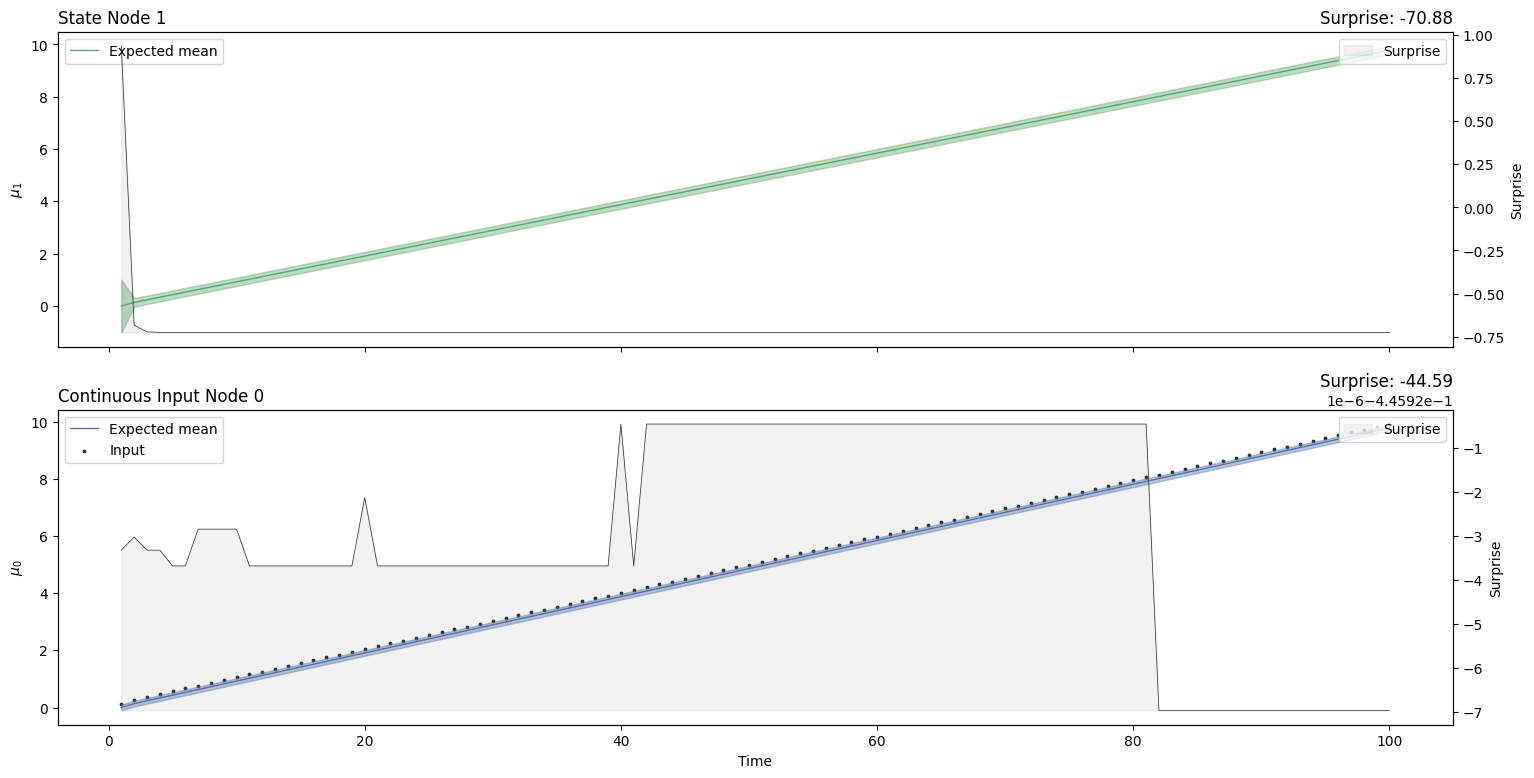

In [101]:
agent_1.attributes[0]["expected_mean"] = 3
agent_1.attributes[0]["expected_precision"] = 1e-2

# Generate predictions with the updated parameters
agent_1.input_data_prediction()

# Plot new trajectories
agent_1.plot_trajectories()

In [102]:
agent_2.attributes

{-1: {'time_step': 0.0},
 0: {'observed': 1,
  'mean': 0,
  'expected_mean': 0.5,
  'precision': 100.0,
  'expected_precision': 1.0,
  'value_coupling_parents': (1.0,),
  'temp': {'value_prediction_error': 0.0}},
 1: {'mean': 0.0,
  'expected_mean': 0.0,
  'precision': 1.0,
  'expected_precision': 1.0,
  'volatility_coupling_children': None,
  'volatility_coupling_parents': None,
  'value_coupling_children': (1.0,),
  'value_coupling_parents': None,
  'tonic_volatility': -4.0,
  'tonic_drift': 0.0,
  'autoconnection_strength': 1.0,
  'observed': 1,
  'temp': {'effective_precision': 0.0,
   'value_prediction_error': 0.0,
   'volatility_prediction_error': 0.0}}}

In [113]:
# Generate predictions for agent_2 based on its internal model and inputs
agent_2.input_data_prediction()
agent_2.attributes

{-1: {'time_step': 0.0},
 0: {'observed': 1,
  'mean': 0,
  'expected_mean': 0.5,
  'precision': 100.0,
  'expected_precision': 1.0,
  'value_coupling_parents': (1.0,),
  'temp': {'value_prediction_error': 0.0}},
 1: {'mean': 0.0,
  'expected_mean': 0.0,
  'precision': 1.0,
  'expected_precision': 1.0,
  'volatility_coupling_children': None,
  'volatility_coupling_parents': None,
  'value_coupling_children': (1.0,),
  'value_coupling_parents': None,
  'tonic_volatility': -4.0,
  'tonic_drift': 0.0,
  'autoconnection_strength': 1.0,
  'observed': 1,
  'temp': {'effective_precision': 0.0,
   'value_prediction_error': 0.0,
   'volatility_prediction_error': 0.0}}}